In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Installing dependencies

Importing required libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import gensim.downloader as api
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Embedding,Bidirectional, Dropout
from keras.layers import *
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.models import Model
from sklearn import metrics
from sklearn.metrics import confusion_matrix

Pre-processing data

In [3]:
df_train = pd.read_csv('/content/drive/MyDrive/MI/data/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/MI/data/test.csv')

In [4]:
y_train = to_categorical(df_train.label.values)
y_test = to_categorical(df_test.label.values)

In [5]:
glove_gensim  = api.load('glove-wiki-gigaword-300')
np.random.seed(1)
vocab = glove_gensim.wv.vocab
print("The total number of words are : ",len(vocab))
print(type(vocab))

[==================================================] 100.0% 376.1/376.1MB downloaded
The total number of words are :  400000
<class 'dict'>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
vocab = list(vocab.keys())
word_vec_dict = {}
for word in vocab:
  word_vec_dict[word] = glove_gensim.wv.get_vector(word)
print("The no of key-value pairs : ",len(word_vec_dict)) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


The no of key-value pairs :  400000


In [8]:
maxi = -1
for i, rev in enumerate(df_train['text']):
  rev = str(rev)
  tokens = rev.split()
  if(len(tokens) > maxi):
    maxi = len(tokens)
print(maxi)

20


In [14]:
df_train['text'] = df_train['text'].astype('string')

In [19]:
df_train.isna().sum()

text     2
label    0
dtype: int64

In [20]:
df_train = df_train.dropna()

In [21]:
tokenizer = Tokenizer()
df_total = pd.concat([df_train['text'], df_test.text], axis = 0)
tokenizer.fit_on_texts(df_total)

In [22]:
max_rev_len = maxi  # max lenght of a word
vocab_size = len(tokenizer.word_index) + 1 # total no of words
embed_dim = 300

In [23]:
print(len(tokenizer.word_index))

10644


In [24]:
X_train = tokenizer.texts_to_sequences(df_train['text']) #converting texts into some numeric sequences 
X_train_pad = pad_sequences(X_train, maxlen = max_rev_len, padding = 'post') #making the length of all numeric sequences equal 
X_test = tokenizer.texts_to_sequences(df_test.text)
X_test_pad = pad_sequences(X_test, maxlen = max_rev_len, padding = 'post')

In [25]:
embed_matrix = np.zeros(shape = (vocab_size,embed_dim))
for word, i in tokenizer.word_index.items():
  embed_vector = word_vec_dict.get(word)
  if embed_vector is not None:  # word is in the vocabulary learned by the w2v model
    embed_matrix[i] = embed_vector
embed_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.04656   ,  0.21318001, -0.0074364 , ...,  0.0090611 ,
        -0.20988999,  0.053913  ],
       [-0.29712   ,  0.094049  , -0.096662  , ...,  0.059717  ,
        -0.22853   ,  0.29602   ],
       ...,
       [ 0.38248   ,  0.027127  , -0.43937999, ...,  0.18257   ,
        -0.25413001,  0.23254   ],
       [ 0.56656998,  0.21641999, -0.11517   , ...,  0.078156  ,
        -0.039554  ,  0.19416   ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

Training the data on the model

In [26]:
def create_model():
  class_num = 2
  model = Sequential()
  model.add(Embedding(input_dim = vocab_size, output_dim = embed_dim, input_length = max_rev_len, weights = [embed_matrix], trainable = False))
  model.add(Dropout(0.2))
  model.add(Bidirectional(LSTM(128, return_sequences = True)))
  model.add(Dropout(0.2))
  model.add(Bidirectional(LSTM(128, return_sequences = True)))
  model.add(Dropout(0.2))
  model.add(Bidirectional(LSTM(64, return_sequences = False)))
  model.add(Dense(class_num, activation = 'softmax'))
  model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = 'accuracy')
  return model

In [27]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 300)           3193500   
                                                                 
 dropout (Dropout)           (None, 20, 300)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 20, 256)          439296    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 20, 256)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 20, 256)          394240    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 20, 256)           0

In [28]:
history_embedding = model.fit(X_train_pad, y_train, epochs = 10, batch_size = 64, validation_split = 0.1, verbose = 1)

Epoch 1/10
101/101 [==============================] - 48s 349ms/step - loss: 0.6317 - accuracy: 0.6455 - val_loss: 0.7964 - val_accuracy: 0.5160
Epoch 2/10
101/101 [==============================] - 36s 356ms/step - loss: 0.5810 - accuracy: 0.6941 - val_loss: 0.8233 - val_accuracy: 0.5105
Epoch 3/10
101/101 [==============================] - 32s 316ms/step - loss: 0.5492 - accuracy: 0.7229 - val_loss: 0.9325 - val_accuracy: 0.5146
Epoch 4/10
101/101 [==============================] - 36s 353ms/step - loss: 0.5123 - accuracy: 0.7522 - val_loss: 0.8977 - val_accuracy: 0.5160
Epoch 5/10
101/101 [==============================] - 34s 334ms/step - loss: 0.4720 - accuracy: 0.7781 - val_loss: 0.9808 - val_accuracy: 0.5188
Epoch 6/10
101/101 [==============================] - 32s 319ms/step - loss: 0.4287 - accuracy: 0.8048 - val_loss: 1.1889 - val_accuracy: 0.5119
Epoch 7/10
101/101 [==============================] - 34s 336ms/step - loss: 0.3917 - accuracy: 0.8194 - val_loss: 1.1484 - val_ac

Visualizing the training and validation results

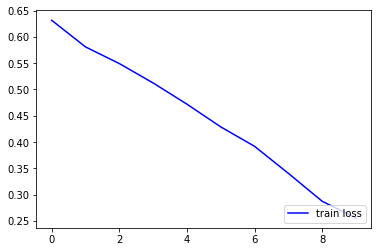

In [29]:
plt.plot(history_embedding.history['loss'], c = 'b', label = 'train loss')
plt.legend(loc = 'lower right')
plt.show()

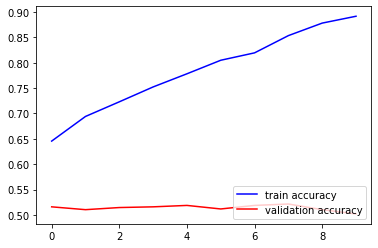

In [30]:
plt.plot(history_embedding.history['accuracy'], c = 'b', label = 'train accuracy')
plt.plot(history_embedding.history['val_accuracy'] , c = 'r', label = 'validation accuracy')
plt.legend(loc = 'lower right')
plt.show()

Extracting classification report and confusion matrix

In [31]:
y_pred = np.argmax(model.predict(X_test_pad), axis = 1)
y_true = np.argmax(y_test, axis = 1)
print(metrics.classification_report(y_true, y_pred))

56/56 [==============================] - 7s 72ms/step
              precision    recall  f1-score   support

           0       0.68      0.46      0.54       851
           1       0.62      0.80      0.70       941

    accuracy                           0.64      1792
   macro avg       0.65      0.63      0.62      1792
weighted avg       0.65      0.64      0.63      1792



In [32]:
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[388 463]
 [185 756]]


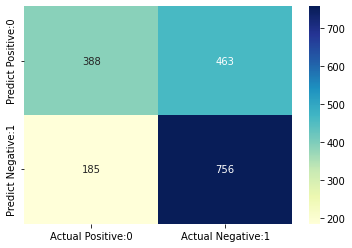

In [33]:
cm_matrix = pd.DataFrame(data = cm, columns = ['Actual Positive:0', 'Actual Negative:1'], index = ['Predict Positive:0', 'Predict Negative:1'])
sns.heatmap(cm_matrix, annot = True, fmt ='d', cmap = 'YlGnBu')